In [1]:
import numpy as np
from graph_tool.all import *
import pandas as pd
import cairo
import configparser
config = configparser.ConfigParser()
a = config.read('config.ini')

In [2]:
%run delay.ipynb

In [3]:
# Nodes
class AbstractNode:
    def __init__(self, name, show_name, vertex, x, y):
        self.name = name
        self.show_name = show_name
        self.vertex = vertex
        self.x = float(x)
        self.y = float(y)

class Node(AbstractNode):
    def __init__(self, nid,name, show_name, vertex, x, y, node_type, surface_url):
        super().__init__(name, show_name, vertex, x, y)
        self.nid = nid
        self.links = []
        self.type = node_type  
        self.surface_url = surface_url
        self.is_in_route = False
        self.total_delay = 0.0
        
    def add_link(self, link):
        self.links.append(link)
        
    def get_total_delay_format(self):
        return f"{self.total_delay:.2e}ms"


class Label(AbstractNode):
    def __init__(self, name, show_name, vertex,main_node,x_off,y_off):
        super().__init__(name, show_name, vertex, main_node.x+float(x_off), main_node.y+float(y_off))


def find_node(nodes,name):
    for node in nodes:
        if node.name == name:
            return node
    return None

In [4]:
# Edges
class AbstractEdge:
    def __init__(self, start_node, end_node, edge):
        self.start_node = start_node
        self.end_node = end_node
        self.edge = edge

class Link(AbstractEdge):
    def __init__(self, start_node, end_node, trans_bandwidth, prop_distance, propagation_speed,loss_up,loss_down, type, edge):
        super().__init__(start_node, end_node, edge)
        self.trans_bandwidth = trans_bandwidth
        self.prop_distance = prop_distance
        self.type = type
        self.loss_up = loss_up
        self.loss_down = loss_down
        self.propagation_speed = propagation_speed
        self.delay_up = 0.0
        self.delay_down = 0.0
        
    def get_destance_format(self):
        return f'Distance:{float(self.prop_distance):.2f}Km'
        
    def get_band_format(self):
        return f'BandWidth:{float(self.trans_bandwidth):.0f}MB'

    def get_self_delay(self,transPackageSize):
        self.delay_up = networkMessageDelay(transPackageSize=transPackageSize,
                                         transBandWidth=self.trans_bandwidth,
                                         propagationDistance=self.prop_distance,
                                         propagationSpeed=self.propagation_speed,
                                         propagationLoss=self.loss_up)
        self.delay_down = networkMessageDelay(transPackageSize=transPackageSize,
                                         transBandWidth=self.trans_bandwidth,
                                         propagationDistance=self.prop_distance,
                                         propagationSpeed=self.propagation_speed,
                                         propagationLoss=self.loss_down)



class Route(AbstractEdge):
    def __init__(self, start_node, end_node, edge):
        super().__init__(start_node, end_node, edge)
        self.delay = 0.0
        
        


In [5]:
#functions
def find_link(links,name1,name2):
    for link in links:
        if (link.start_node.name, link.end_node.name) in [(name1, name2), (name2, name1)]:
            return link
    return None
def add_new_link(nodes,start_node_name, end_node_name, trans_bandwidth, prop_distance,propagation_speed,loss_up,loss_down, type):
    start_node = find_node(nodes,start_node_name)
    end_node = find_node(nodes,end_node_name)
    if (start_node is None) or (end_node is None):
        return
    new_edge = g.add_edge(start_node.vertex,end_node.vertex)
    new_link = Link(start_node=start_node
                    ,end_node=end_node
                    ,trans_bandwidth=trans_bandwidth
                    ,prop_distance=prop_distance
                    ,propagation_speed=propagation_speed
                    ,loss_up=loss_up
                    ,loss_down=loss_down
                    ,type=type
                    ,edge=new_edge
                    )
    return new_link
    
def add_new_route(nodes,start_node_name, end_node_name):
    start_node = find_node(nodes,start_node_name)
    end_node = find_node(nodes,end_node_name)
    if (start_node is None) or (end_node is None):
        return
    new_edge = g.add_edge(start_node.vertex,end_node.vertex)
    start_node.is_in_route = True
    end_node.is_in_route = True
    new_link = Route(start_node=start_node
                    ,end_node=end_node
                    ,edge=new_edge)
    return new_link

def find_node_by_name(nodes,name):
    for node in nodes:
        if node.name == name:
            return node
    return None

def find_link_by_nodes(links,node1,node2):
    for link in links:
        if (link.start_node, link.end_node) in [(node1, node2), (node2, node1)]:
            return link
    return None

def get_toward(link,start_node,end_node):
    if(link.start_node == start_node and link.end_node == end_node):
        return "up"
    else:
        return "down"

def get_delay_format(delay):
    return f'Delay:{delay:.2e}ms'

In [6]:
# basic var
# if this part changed, all cell below need restart 
nodes = []
links = []
routes = []
labels = []
scene_path = config.get('config', 'scene_path')+"sim_manual/"
package_size = float(config.get('config', 'package_size'))
g = Graph()
g_sfcs = g.new_vertex_property("object")
g_pos = g.new_vertex_property("vector<float>")
g_shape = g.new_vertex_property("string")
g_vorder = g.new_vertex_property("int")
g_eorder = g.new_edge_property("int")

g_v_label = g.new_vertex_property("string")
g_v_size = g.new_vertex_property("double")
g_v_color = g.new_vertex_property("string")
g_v_fill_color = g.new_vertex_property("string")
g_v_pen_width = g.new_vertex_property("float")
g_v_halo = g.new_vertex_property("bool")
g_v_text_position = g.new_vertex_property("float")
g_v_text_offset = g.new_vertex_property("vector<int>")
g_v_font_size = g.new_vertex_property("int")
g_v_halo_color = g.new_vertex_property("string")
g_v_halo_size = g.new_vertex_property("float")

g_e_end_mark = g.new_edge_property("string")
g_e_pen_width = g.new_edge_property("int")
g_e_marker_size = g.new_edge_property("int")
g_e_text = g.new_edge_property("string")
g_e_text_parallel = g.new_edge_property("bool")
g_e_text_font_size = g.new_edge_property("int")
g_e_color = g.new_edge_property("string")
g_e_text_distance = g.new_edge_property("float")
g_e_up_delay = g.new_edge_property("float")
g_e_down_delay = g.new_edge_property("float")

In [7]:
# create nodes
nodes_df = pd.read_csv(scene_path+'nodes.csv')
for i in range(len(nodes_df)):
    new_node = Node(nid=nodes_df.iloc[i]["id"]
                          ,name=nodes_df.iloc[i]["name"]
                          ,show_name=nodes_df.iloc[i]["show_name"]
                          ,vertex=g.add_vertex()
                          ,node_type=nodes_df.iloc[i]["type"]
                          ,surface_url=nodes_df.iloc[i]["surface"]
                          ,x=nodes_df.iloc[i]["x"]
                          ,y=nodes_df.iloc[i]["y"]
                         )
    nodes.append(new_node)
    n_v = new_node.vertex
    if(len(new_node.surface_url)):
        g_sfcs[n_v] = cairo.ImageSurface.create_from_png(config.get('config', 'resource_path')+new_node.surface_url)
    g_v_label[n_v] = new_node.show_name
    g_v_color[n_v] = "w"
    g_v_fill_color[n_v] = "w"
    g_v_pen_width[n_v] = 0.0
    g_v_text_position[n_v] = -0.5
    g_v_text_offset[n_v] = [0,0]
    g_v_font_size[n_v] = 20
    g_v_size[n_v] = 50
    g_pos[n_v]=[new_node.x,new_node.y]

In [8]:
# create edges
edges_df = pd.read_csv(scene_path+'edges.csv')
for i in range(len(edges_df)):
    new_link = add_new_link(nodes=nodes,
                            start_node_name=edges_df.iloc[i]["start_node_name"], 
                            end_node_name=edges_df.iloc[i]["end_node_name"], 
                            trans_bandwidth=edges_df.iloc[i]["trans_bandwidth"], 
                            prop_distance=edges_df.iloc[i]["prop_distance"],
                            propagation_speed=edges_df.iloc[i]["propagation_speed"],
                            loss_up=edges_df.iloc[i]["loss_up"],
                            loss_down=edges_df.iloc[i]["loss_down"],
                            type=0)
    if new_link is not None:
        links.append(new_link)
        new_link.get_self_delay(package_size)
        links.append(new_link)
        l_e = new_link.edge
        g_eorder[l_e] = 0
        g_e_up_delay[l_e] = new_link.delay_up
        g_e_down_delay[l_e] = new_link.delay_down
        g_e_color[l_e] = "black"
        g_e_text_parallel[l_e] = True
        g_e_text[l_e] = f'{new_link.get_destance_format()} {new_link.get_band_format()}'
        g_e_text_font_size[l_e] = 10
        g_e_end_mark[l_e] = "none"
        g_e_pen_width[l_e] = 1
        g_e_text_distance[l_e] = -10.0
#         g_e_dash_style[l_e] = [1, 1, 0]
#         g_e_dash_style[l_e] = [10000, 100000, 0]

In [9]:
# create routes
routes_df = pd.read_csv(scene_path+'routes.csv')
total_delay = 0.0
a_start_node = None
a_end_node = None
for i in range(len(routes_df)):
    start_node_name=routes_df.iloc[i]["start_node_name"]
    end_node_name=routes_df.iloc[i]["end_node_name"]
    start_node = find_node_by_name(nodes,start_node_name)
    end_node = find_node_by_name(nodes,end_node_name)
    if find_node_by_name(nodes,start_node_name).type == 1:
        a_start_node = find_node_by_name(nodes,start_node_name)
    if find_node_by_name(nodes,end_node_name).type == 1:
        a_end_node = find_node_by_name(nodes,end_node_name)
    link = find_link_by_nodes(links,start_node,end_node)
    new_route = add_new_route(nodes,start_node_name=start_node.name,end_node_name=end_node.name)
    g_e_text_parallel[new_route.edge] = True
    g_e_end_mark[new_route.edge] = "arrow"
    g_e_pen_width[new_route.edge] = 2
    g_e_marker_size[new_route.edge] = 10
    if(get_toward(link,start_node,end_node)=="up"):
        g_e_color[new_route.edge] = "g"
        total_delay += link.delay_up
        g_eorder[new_route.edge] = 1
    else:
        g_e_color[new_route.edge] = "b"
        total_delay += link.delay_down
        g_eorder[new_route.edge] = 2
    g_e_text[new_route.edge] = get_delay_format(total_delay)
    g_e_text_font_size[new_route.edge] = 10
    g_e_text_distance[new_route.edge] = 10.0
#         g_e_dash_style[new_route.edge] = [10, 10, 0]

Total Package Size = 1024.0Byte


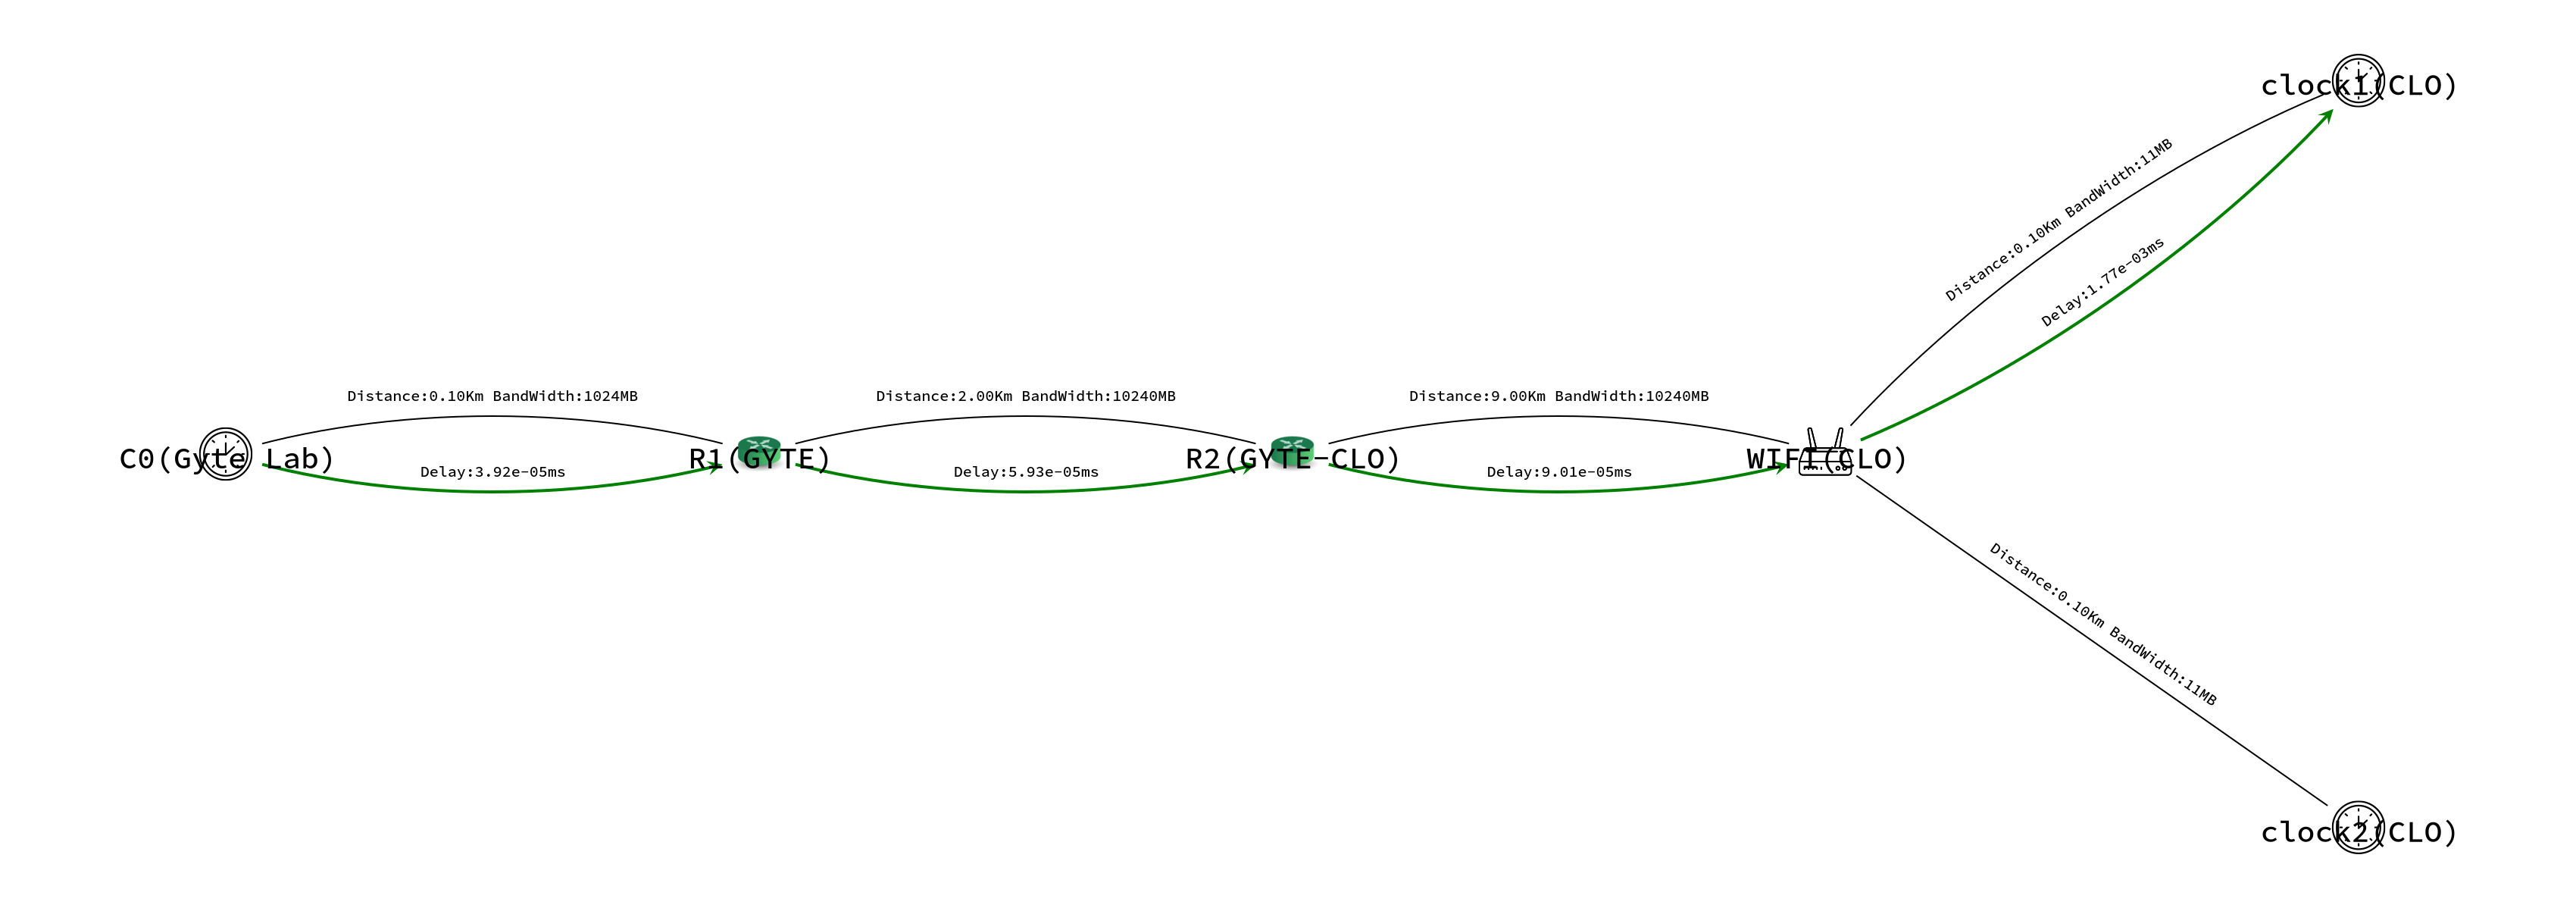

In [10]:
print(f'Total Package Size = {package_size}Byte')
a = graph_draw(g
               ,pos=g_pos
               ,vertex_text=g_v_label
               ,output_size=(1700,1700)
               ,vertex_surface=g_sfcs
               ,vertex_size=g_v_size
               ,vertex_color=g_v_color
               ,vertex_fill_color=g_v_fill_color
               ,vertex_halo=g_v_halo
               ,vertex_font_size=g_v_font_size
               ,vertex_text_offset=g_v_text_offset
               ,vertex_text_position=g_v_text_position
               ,vertex_pen_width=g_v_pen_width
               ,edge_end_marker=g_e_end_mark
               ,edge_pen_width=g_e_pen_width
               ,edge_marker_size=g_e_marker_size
               ,edge_text=g_e_text
               ,edge_text_parallel=g_e_text_parallel
               ,edge_font_size=g_e_text_font_size
               ,edge_color=g_e_color
               ,edge_text_distance=g_e_text_distance
              )